# Exercise 1

Design: Propose a logging schema for Sqwish’s online learning system. It should record everything needed to reproduce training and do later analysis. For each user request, what would you log? (Think: a unique request ID, user context features, chosen prompt/model, all model outputs maybe, any user click or outcome, timestamps, the probability or propensity of the chosen action if using a stochastic policy, etc.). Write a structured list of fields and justify each (why is it needed? e.g. propensity is needed for IPS in OPE).

## Solution

## Solution: Logging schema (concise)

### Decision event (one row per request)
- `request_id`, `timestamp_ms`, `session_id`, `user_id_hash` (join keys: link this decision to later rewards/errors)
- `trace_id` (distributed tracing: follow the request across services and break down latency)
- `context_features`, `feature_version` (exact inputs the policy used at decision time)
- `candidate_actions`, `chosen_action`, `action_params` (what was available + what we did)
- `logging_policy_id`, `logging_policy_version`, `propensity` (needed for IPS/DR OPE)
- `exploration_state` (epsilon/UCB alpha/TS params; why it explored)
- `latency_ms_total`, `latency_ms_by_stage`, `token_usage`, `estimated_cost_usd`, `error_flags`
- `safety_labels`, `safety_score`, `safety_model_version`, `mitigation_taken`

### Reward/outcome event (separate row, can arrive later)
- `request_id` (join key: attach this outcome back to the original decision)
- `reward_timestamp_ms` (when the outcome was observed)
- `reward_type`, `reward_value` (what happened + numeric value)
- `reward_observation_window` (what window you waited for, e.g. 24h conversion)
- `attribution_model_version` (if credit assignment/labeling uses a model)

### Minimal template 
```json
{
  "request_id": "string",
  "timestamp_ms": "int",
  "session_id": "string",
  "user_id_hash": "string",
  "context_features": "object<string, number>",
  "feature_version": "string",
  "candidate_actions": "array<string>",
  "chosen_action": "string",
  "action_params": "object<string, number|string|bool>",
  "logging_policy_id": "string",
  "logging_policy_version": "string",
  "propensity": "float (0..1)",
  "latency_ms_total": "int",
  "token_usage": "object{prompt:int, completion:int}",
  "estimated_cost_usd": "float",
  "safety_labels": "array<string>",
  "error_flags": "array<string>"
}
```

### Type legend
| Type | Meaning | Example |
| --- | --- | --- |
| `string` | text | `"req_abc123"` |
| `int` | whole number | `123` |
| `float` | decimal number | `0.42` |
| `bool` | true/false | `true` |
| `array<string>` | list of strings | `["pii", "hate"]` |
| `object<string, number>` | map: string → number | `{ "len": 42 }` |
| `object<string, number\|string\|bool>` | map: string → mixed value | `{ "temperature": 0.7, "model": "gpt-5", "stream": false }` |



# Exercise 2

Analysis: You have deployed a bandit that optimizes prompts. After a week, you examine results and see overall user satisfaction went up 5%. However, for new users (first-time visitors) satisfaction dropped. How would you investigate this? Outline an experiment or analysis using logs to diagnose why the policy might be underperforming for new users (maybe it over-explored or didn’t personalize properly for cold-start users). What changes to the algorithm could you consider (e.g. epsilon-greedy for new users until enough data)?

## Solution

## Solution

### Investigation 
- Slice new-user satisfaction by query bucket/intent and by `logging_policy_version` to find when/where the drop starts.
- Compare new vs returning behavior: `chosen_action` mix and `exploration_state`.
- Check labels: reward delay (`reward_timestamp_ms - timestamp_ms`) and missing outcomes for new users.
- Before shipping changes, estimate the fix with OPE (IPS/DR) using logged `propensity`.

### One mitigation
- New-user safe exploration: for `is_new_user`, keep exploration small (e.g., low `epsilon`) and only explore within a shortlist of “safe” prompts; don’t try risky/untested prompts on first-time users.

### Rollout + monitoring
- Canary to a small % of new-user traffic; watch new-user satisfaction and overall as a sanity check.



# Exercise 3

Coding: Using an open bandit dataset (e.g. the Open Bandit Pipeline’s logged data if available, or simulate one), perform an off-policy evaluation of a hypothetical new policy. For example, use logged data from a uniform random policy on a classification task as bandit feedback. Define a new deterministic policy (like always choose arm 1 for certain feature values and arm 2 otherwise). Use IPS and Doubly Robust to estimate the new policy’s reward from the logs. Compare that to the actual reward if you run the new policy on the dataset (if ground truth available). This exercise solidifies understanding of OPE’s value and limitations (if the policy is very different, IPS variance will be high).

## Solution

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


Loaded OBD with behavior_policy='bts', campaign='all'

--- OBD: quick stats ---
n_rounds:  10,000  (number of logged interactions)
n_actions: 80  (number of possible actions/items)
context shape: (10000, 22)  (rows = interactions, columns = features)
reward mean (click rate): 0.0042  (overall positive rate)
pscore quantiles (probability of the logged action):
min    0.000045
p01    0.000955
p05    0.003410
p50    0.064455
p95    0.342968
p99    0.714599
max    0.954240
dtype: float64
  - tiny pscore means high IPS/DR variance
context NaN rate: 0.000000  (missing feature fraction)


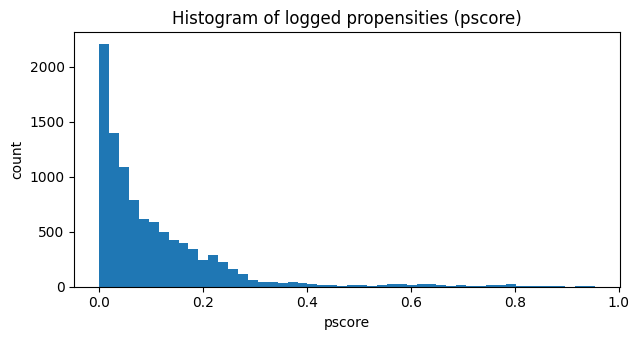

In [7]:
# Exercise 3: Off-Policy Evaluation (OPE) with Open Bandit Dataset (OBD)

from pathlib import Path
import sys

# Ensure Day_14 is on sys.path for local imports in notebooks.
repo_root = Path.cwd()
day14_path = repo_root / "Day_14"
if str(day14_path) not in sys.path:
    sys.path.insert(0, str(day14_path))

from obp_setup import load_obd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load dataset ---
obd, bandit_feedback = load_obd(campaign="all")

a = np.asarray(bandit_feedback["action"]).astype(int)
r = np.asarray(bandit_feedback["reward"]).astype(float)
pscore = np.asarray(bandit_feedback["pscore"]).astype(float)
X = np.asarray(bandit_feedback["context"]).astype(float)

n_rounds = int(bandit_feedback.get("n_rounds", len(a)))
n_actions = int(bandit_feedback.get("n_actions", int(a.max()) + 1))

print("\n--- OBD: quick stats ---")
print(f"n_rounds:  {n_rounds:,}  (number of logged interactions)")
print(f"n_actions: {n_actions:,}  (number of possible actions/items)")
print(f"context shape: {X.shape}  (rows = interactions, columns = features)")
print(f"reward mean (click rate): {r.mean():.4f}  (overall positive rate)")

q = np.quantile(pscore, [0.0, 0.01, 0.05, 0.5, 0.95, 0.99, 1.0])
print("pscore quantiles (probability of the logged action):")
print(pd.Series(q, index=["min", "p01", "p05", "p50", "p95", "p99", "max"]))
print("  - tiny pscore means high IPS/DR variance")

nan_rate = float(np.isnan(X).mean())
print(f"context NaN rate: {nan_rate:.6f}  (missing feature fraction)")

plt.figure(figsize=(6.5, 3.5))
plt.hist(pscore, bins=50)
plt.title("Histogram of logged propensities (pscore)")
plt.xlabel("pscore")
plt.ylabel("count")
plt.tight_layout()
plt.show()



In [8]:

K = 5
counts = np.bincount(a, minlength=n_actions)
topk = counts.argsort()[-K:][::-1]
print(f"Top-{K} actions by frequency: {topk.tolist()} (counts={counts[topk].tolist()})")

mask = np.isin(a, topk)
aK_raw = a[mask]
rK = r[mask]
psK = pscore[mask]
XK = X[mask]

# Remap action ids to {0..K-1}
a_map = {int(act): i for i, act in enumerate(topk)}
aK = np.vectorize(a_map.get)(aK_raw).astype(int)

print(f"\n--- After filtering to {K} actions ---")
print(f"n_rounds_K: {len(aK):,}")
print(f"reward mean: {rK.mean():.4f}")
print("pscore quantiles (filtered rows):")
print(pd.Series(np.quantile(psK, [0.0, 0.01, 0.5, 0.99, 1.0]), index=["min", "p01", "p50", "p99", "max"]))

# --- Define a deterministic target policy ---
# Bucket context[0] into K quantiles -> action in {0..K-1}
x0 = XK[:, 0]
edges = np.quantile(x0, np.linspace(0, 1, K + 1))
a_tgt = np.digitize(x0, edges[1:-1], right=True)

print("\nTarget policy rule:")
print(f"  choose action=bin(context[0], {K} quantiles)")
print("Target policy action rate:")
print(pd.Series(a_tgt).value_counts(normalize=True).sort_index())



Top-5 actions by frequency: [51, 39, 7, 61, 59] (counts=[1105, 756, 741, 704, 651])

--- After filtering to 5 actions ---
n_rounds_K: 3,957
reward mean: 0.0053
pscore quantiles (filtered rows):
min    0.001590
p01    0.010483
p50    0.143990
p99    0.663412
max    0.867205
dtype: float64

Target policy rule:
  choose action=bin(context[0], 5 quantiles)
Target policy action rate:
0    1.0
dtype: float64


In [13]:
# --- OPE: IPS with bootstrap confidence intervals ---

# For numerical stability if some propensities are tiny.
psK_clip = np.clip(psK, 1e-6, None)

aK_s, rK_s, psK_s, XK_s, a_tgt_s = aK, rK, psK_clip, XK, a_tgt

K = int(aK_s.max()) + 1
print(f"Using n={len(aK_s):,} rows for OPE with K={K}")

# IPS
w = (aK_s == a_tgt_s).astype(float) / psK_s
ips_hat = float(np.mean(w * rK_s))

print("\nPoint estimate:")
print(f"  IPS: {ips_hat:.6f}")



Using n=3,957 rows for OPE with K=5

Point estimate:
  IPS: 0.022404


# Exercise 4

Monitoring: List 3 metrics you would put on a dashboard for the live Sqwish system and why. For example: “Cumulative regret” - to watch if the learning is improving over a non-learning baseline; “10th percentile reward” - to ensure we’re not badly serving a subset of users even if average looks good; “Unsafe response count per 1000 interactions” - to catch any increase in policy violations. Explain briefly how each metric helps ensure the system is healthy.


## Solution

- Quality: average reward plus p10/p50/p90/p99, sliced by new vs returning users, averages can hide a bad tail.
- Latency: p50/p90/p95/p99 end-to-end and ttft latency.
- Cost: cost per request.

